## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [2]:
# Install libraries the first time
# ! conda install fastai::fastai conda-forge::yfinance pandas pathlib numpy

### Importing Required Libraries

In [3]:
from fastai.tabular.all import *
from fastai.metrics import rmse, mae
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pathlib

### Variables

In [4]:
# Model settings
modelName = 'stockScreenerV2.1'
trainingData = 'stockData.csv'
getNewData = False 
trainNewModel = True
predictionTarget = 'DRS'  # 'ALL' for all, 'x%', 'None' for no prediction

# Training parameters
trainingSize = 200  # Number of stocks to use for training
timeFrame = '10y'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
contNames = ['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'EV/EBIT', 'ROIC']
catNames = ['Industry', 'Date']
batchSize = 512
epochs = round(0.5+trainingSize/10)

# Testing parameters
testSize = 200  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Functions

In [5]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    try:
        ticker = yf.Ticker(ticker_symbol)
        end_date = datetime.now().date()
        
        # Calculate required date range
        if timeframe == 'max':
            hist = ticker.history(period='max')
        else:
            years = int(timeframe[:-1])
            start_date = end_date - pd.DateOffset(years=years + buffer)
            
            # First check if ticker has existed long enough
            try:
                hist = ticker.history(start=start_date, end=end_date)
            except Exception as e:
                print(f"Data unavailable for {ticker_symbol} ({timeframe}): {e}")
                return pd.DataFrame()

        if hist.empty:
            print(f"No data found for {ticker_symbol} ({timeframe})")
            return pd.DataFrame()

        # Calculate future changes only if we have enough data points
        if len(hist) < 300:  # Minimum ~1.5 years of trading days
            print(f"Insufficient data for {ticker_symbol} ({len(hist)} rows)")
            return pd.DataFrame()

        # Calculate future price change
        hist['Future Year Change'] = (hist['Close'].shift(-252) / hist['Close'] - 1)
        hist = hist.dropna(subset=['Future Year Change'])
        
        return hist[['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 
            'Future Year Change']].reset_index()

    except Exception as e:
        print(f"Error processing {ticker_symbol}: {str(e)}")
        return pd.DataFrame()

In [6]:
def calculateApproxEBIT(tickerSymbol):
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        ebit = operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
        return ebit if ebit and ebit != 0 else None  # Avoid zero division
    except Exception as e:
        return None

In [7]:
def enrichDataWithMetrics(histData):
    # Initialize columns with NaN if they don't exist
    if 'EV/EBIT' not in histData.columns:
        histData['P/E'] = np.nan
    if 'EV/EBIT' not in histData.columns:
        histData['EV/EBIT'] = np.nan
    if 'ROIC' not in histData.columns:
        histData['ROIC'] = np.nan
    
    for ticker in histData['Ticker'].unique():
        try:
            evInfo = yf.Ticker(ticker).info
            totalDebt, cash, sharesOutstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            pass
    return histData

In [8]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        evInfo = yf.Ticker(ticker_symbol).info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')

        # Return as a DataFrame
        return pd.DataFrame([{
            'Ticker': ticker_symbol,
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [9]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        evInfo = ticker.info
        total_debt, cash, shares_outstanding = evInfo.get('totalDebt', 0), evInfo.get('totalCash', 0), evInfo.get('sharesOutstanding', None)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = yf.Ticker(ticker_symbol).info.get('industry', 'Unknown')
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception:
        return pd.DataFrame()

#### Download and Process Historical Data

In [10]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()
    valid_tickers = []
    
    for ticker in trainingTickers:
        print(f"Processing {ticker}...")
        data = calculateFutureYearChange(ticker, timeFrame)
        if not data.empty:
            data['Ticker'] = ticker
            data['Industry'] = yf.Ticker(ticker).info.get('industry', 'Unknown')
            data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
            
            # Enrich individual ticker data first
            ticker_data = enrichDataWithMetrics(data)
            histData = pd.concat([histData, ticker_data])
            
            # Check if metrics were added
            if 'ROIC' not in ticker_data.columns:
                print(f"WARNING: Failed to add metrics for {ticker}")
            
            valid_tickers.append(ticker)
        else:
            print(f"Skipped {ticker} - insufficient data")

    print(f"\nColumns in final dataset: {histData.columns.tolist()}")
    
    if not histData.empty:
        histData = enrichDataWithMetrics(histData)
        histData.to_csv(dataFolder / trainingData, index=True)
        # Verify no future targets leaked to past dates
        latest_date = pd.to_datetime(histData['Date']).max()
        if 'Future Year Change' in histData.columns:
            target_dates = histData[histData['Future Year Change'].notnull()]['Date']
            if any(pd.to_datetime(target_dates) > latest_date):
                raise ValueError("CRITICAL: Analyst targets contain future dates!")
        print(f"Saved training data with {len(histData)} rows")
    else:
        print("Warning: No data collected - check your tickers list")

In [5]:
import pandas as pd
import yfinance as yf

def get_market_cap(ticker):
    try:
        company = yf.Ticker(ticker)
        info = company.info
        return info.get('marketCap', None)
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

# Read the CSV file
df = pd.read_csv(testFolder / 'tickers.csv')

# Fetch market cap for each ticker and add it as a new column
df['Market Cap'] = df['Ticker'].apply(get_market_cap)

# Drop rows where market cap data is missing
df_clean = df.dropna(subset=['Market Cap'])

# Filter rows where market cap is at least 50 million USD
filtered_df = df_clean[df_clean['Market Cap'] >= 50_000_000]

# Save the filtered data to a new CSV file
filtered_df.to_csv(testFolder / 'filteredTickers.csv', index=False)

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AAN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AAN&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ABC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ABC&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AEL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=AEL&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/AFT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&f

Error fetching data for DTQ: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DTT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DTZ: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DUA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DUC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DUK: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DUKH: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DV: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DVA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DVM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DVN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DVR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DW: 

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FAF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FAF&crumb=Edge%3A+Too+Many+Requests
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FAM?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FAM&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FBS-A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FBS-A&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FCE.B?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDom

Error fetching data for HDB: ('Connection broken: IncompleteRead(1 bytes read, 1 more expected)', IncompleteRead(1 bytes read, 1 more expected))


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HE-U?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HE-U&crumb=wMYLnRQb6Q9
500 Server Error: Internal Server Error for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HEI.A?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HEI.A&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HEP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=HEP&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/HHC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=f

Error fetching data for MCP-A: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MCQ: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MCR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MCS: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MCV: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MCY: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MD: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MDC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MDP: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MDR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MDT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MDU: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MED

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MYI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MYI&crumb=Edge%3A+Too+Many+Requests
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MYJ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=MYJ&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NAD-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=NAD-C&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NAN-C?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDom

Error fetching data for PZE: Too Many Requests. Rate limited. Try after a while.
Error fetching data for PZN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for Q: Too Many Requests. Rate limited. Try after a while.
Error fetching data for QEP: Too Many Requests. Rate limited. Try after a while.
Error fetching data for QEPM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for QIHU: Too Many Requests. Rate limited. Try after a while.
Error fetching data for QRE: Too Many Requests. Rate limited. Try after a while.
Error fetching data for QTM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for QUAD: Too Many Requests. Rate limited. Try after a while.
Error fetching data for R: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RAD: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RAI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RALY:

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SDT?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SDT&crumb=Edge%3A+Too+Many+Requests
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SEAS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SEAS&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SEM.W?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SEM.W&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SFE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDom

Error fetching data for TXT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TXTR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TY: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TY.P: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TYC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TYG: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TYG-B: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TYL: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TYN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TYY: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TYY-C: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TZF: Too Many Requests. Rate limited. Try after a while.
Error fetching data for

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ACIW?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ACIW&crumb=Edge%3A+Too+Many+Requests
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ACRX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ACRX&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ACST?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ACST&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ADES?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDo

Error fetching data for BDSI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BEAT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BEAV: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BEBE: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BECN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BELFA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BELFB: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BERK: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BFIN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BGCP: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BGFV: Too Many Requests. Rate limited. Try after a while.
Error fetching data for BGMD: Too Many Requests. Rate limited. Try after a while.
Error fetching

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CHNR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CHNR&crumb=Edge%3A+Too+Many+Requests
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CHUY?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CHUY&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CISAA?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=CISAA&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/CISAU?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&cor

Error fetching data for DRYS: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DSCI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DSCO: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DSGX: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DSKX: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DSPG: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DSWL: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DTLK: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DTSI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DTV: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DVAX: Too Many Requests. Rate limited. Try after a while.
Error fetching data for DVCR: Too Many Requests. Rate limited. Try after a while.
Error fetching da

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FCFS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FCFS&crumb=Edge%3A+Too+Many+Requests
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FCHI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FCHI&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FREE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FREE&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FRGI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDo

Error fetching data for HTHT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HTLD: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HTLF: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HTWO: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HTWR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HUBG: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HURC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HURN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HWAY: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HWBK: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HWCC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for HWKN: Too Many Requests. Rate limited. Try after a while.
Error fetching d

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/KIOR?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=KIOR&crumb=Edge%3A+Too+Many+Requests
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LIFE?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LIFE&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/LSI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=LSI&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/MCBC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDoma

Error fetching data for MPAA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MPAC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MPB: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MPEL: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MPET: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MPWR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MRCC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MRCY: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MRGE: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MRLN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MRTN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for MRTX: Too Many Requests. Rate limited. Try after a while.
Error fetching da

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ORBK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ORBK&crumb=Edge%3A+Too+Many+Requests
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/PACW?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=PACW&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/PCTI?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=PCTI&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/PFIN?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDo

Error fetching data for RCKB: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RCKY: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RCMT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RCON: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RCPT: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RDA: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RDCM: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RDEN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RDHL: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RDI: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RDIB: Too Many Requests. Rate limited. Try after a while.
Error fetching data for RDNT: Too Many Requests. Rate limited. Try after a while.
Error fetching dat

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SKUL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SKUL&crumb=Edge%3A+Too+Many+Requests
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SLMAP?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SLMAP&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SMMF?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=SMMF&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/SPLK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&cors

Error fetching data for TTWO: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TUES: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TWER: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TWGP: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TWIN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TWMC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TWTC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TXCC: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TXN: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TXRH: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TYPE: Too Many Requests. Rate limited. Try after a while.
Error fetching data for TZOO: Too Many Requests. Rate limited. Try after a while.
Error fetching da

401 Client Error: Unauthorized for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WLBPZ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WLBPZ&crumb=Edge%3A+Too+Many+Requests
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WMGIZ?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WMGIZ&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WSFSL?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WSFSL&crumb=wMYLnRQb6Q9
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/XGTIW?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail

## Model Training

In [43]:
if trainNewModel:
    TRAINING_CUTOFF = pd.to_datetime('2023-01-01')

    df = pd.read_csv(dataFolder / trainingData)
    dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC']).copy()

    # Convert 'Date' to datetime, parse UTC-aware dates, then make naive
    dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce', utc=True).dt.tz_convert(None)
    dfCleaned = dfCleaned.dropna(subset=['Date'])

    # Clean 'EV/EBIT' and reset index
    dfCleaned['EV/EBIT'] = dfCleaned['EV/EBIT'].replace([np.inf, -np.inf], np.nan)
    dfCleaned = dfCleaned.dropna(subset=['EV/EBIT', 'ROIC'])
    dfCleaned = dfCleaned.reset_index(drop=True)
    dfCleaned.to_csv(dataFolder / trainingData, index=False)

    # Check for empty data
    if dfCleaned.empty:
        raise ValueError("The cleaned DataFrame is empty.")

    # Create splits with valid indices
    train_mask = dfCleaned['Date'] < TRAINING_CUTOFF
    valid_mask = ~train_mask
    splits = (list(dfCleaned[train_mask].index), list(dfCleaned[valid_mask].index))

    if not splits[0] or not splits[1]:
        raise ValueError("Empty training or validation split.")

    # Proceed with TabularPandas
    to = TabularPandas(
        dfCleaned, 
        procs=[Categorify, FillMissing, Normalize],
        y_names=yNames,
        cat_names=catNames, 
        cont_names=contNames,
        splits=splits
    )

    dls = to.dataloaders(bs=batchSize)

Learning rate finder results: SuggestedLRs(minimum=1.318256749982538e-07, steep=9.12010818865383e-07)
Training for 20 epochs...


epoch,train_loss,valid_loss,_rmse,mae,time
0,122.853729,0.241096,0.491015,0.359312,00:11
1,236.540298,0.279050,0.528252,0.360688,00:11
2,70.319817,0.210892,0.459230,0.334198,00:10
3,67.417587,9.647026,3.105966,0.336525,00:11
4,101.624313,0.208268,0.456364,0.340109,00:10
5,168.687119,0.197813,0.444761,0.319167,00:10
6,132.916412,0.478087,0.691438,0.313358,00:11
7,227.851196,0.190618,0.436599,0.316867,00:17
8,123.041595,0.201517,0.448906,0.330634,00:12
9,153.299866,0.197398,0.444295,0.322546,00:10


Model training complete


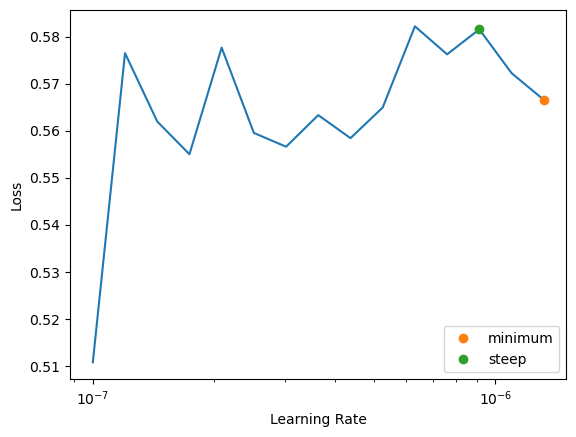

In [44]:
if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    # Learning rate finder
    lr_find_results = learn.lr_find(suggest_funcs=(minimum, steep))

    # Debugging information
    print(f"Learning rate finder results: {lr_find_results}")

    # Extract learning rates
    lr_min, lr_steep = lr_find_results

    # Check if learning rates are valid
    if lr_min is None or lr_steep is None or lr_min == 0 or lr_steep == 0:
        raise ValueError("Learning rate finder did not return valid learning rates.")

    # Train
    print(f"Training for {epochs} epochs...")
    learn.fit_one_cycle(epochs, lr_max=lr_steep)
    print("Model training complete")

    learn.export(modelFolder / f'{modelName}.pkl')

## Testing and benchmarking

$JPM-D: possibly delisted; no timezone found


Error fetching data for JPM-D: No historical data available for JPM-D around 2024-01-29.


$WBB: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for WBB: No historical data available for WBB around 2024-01-29.


$CONE: possibly delisted; no timezone found


Error fetching data for CONE: No historical data available for CONE around 2024-01-29.


$DATE: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for DATE: No historical data available for DATE around 2024-01-29.


$GPX: possibly delisted; no timezone found


Error fetching data for GPX: No historical data available for GPX around 2024-01-29.


$GG: possibly delisted; no timezone found


Error fetching data for GG: No historical data available for GG around 2024-01-29.


$TCB.W: possibly delisted; no timezone found
$ARO: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$ACAT: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for TCB.W: No historical data available for TCB.W around 2024-01-29.
Error fetching data for ARO: No historical data available for ARO around 2024-01-29.
Error fetching data for ACAT: No historical data available for ACAT around 2024-01-29.
Error fetching data for CHSCP: unsupported operand type(s) for /: 'NoneType' and 'float'


$UBA: possibly delisted; no timezone found
$GMT: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for UBA: No historical data available for UBA around 2024-01-29.
Error fetching data for GMT: No historical data available for GMT around 2024-01-29.


$TCB-B: possibly delisted; no timezone found
$QTWW: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for TCB-B: No historical data available for TCB-B around 2024-01-29.
Error fetching data for QTWW: No historical data available for QTWW around 2024-01-29.


$CCIH: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$AOI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CCIH: No historical data available for CCIH around 2024-01-29.
Error fetching data for AOI: No historical data available for AOI around 2024-01-29.


$MCGC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for MCGC: No historical data available for MCGC around 2024-01-29.


$EIHI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for EIHI: No historical data available for EIHI around 2024-01-29.


$STI.A: possibly delisted; no timezone found


Error fetching data for STI.A: No historical data available for STI.A around 2024-01-29.


$IDTI: possibly delisted; no timezone found


Error fetching data for IDTI: No historical data available for IDTI around 2024-01-29.


$HPJ: possibly delisted; no timezone found


Error fetching data for HPJ: No historical data available for HPJ around 2024-01-29.


$MBT: possibly delisted; no timezone found
$SCMP: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for MBT: No historical data available for MBT around 2024-01-29.
Error fetching data for SCMP: No historical data available for SCMP around 2024-01-29.


$RBS-L: possibly delisted; no timezone found


Error fetching data for RBS-L: No historical data available for RBS-L around 2024-01-29.


$NILE: possibly delisted; no timezone found


Error fetching data for NILE: No historical data available for NILE around 2024-01-29.


$MEILW: possibly delisted; no timezone found
$ROSG: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for MEILW: No historical data available for MEILW around 2024-01-29.
Error fetching data for ROSG: No historical data available for ROSG around 2024-01-29.


$HAR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for HAR: No historical data available for HAR around 2024-01-29.


$HAV: possibly delisted; no timezone found
$FSC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for HAV: No historical data available for HAV around 2024-01-29.
Error fetching data for FSC: No historical data available for FSC around 2024-01-29.


$MTB.P: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for MTB.P: No historical data available for MTB.P around 2024-01-29.


$GDI: possibly delisted; no timezone found


Error fetching data for GDI: No historical data available for GDI around 2024-01-29.


$PL-C: possibly delisted; no timezone found


Error fetching data for PL-C: No historical data available for PL-C around 2024-01-29.


$PGNX: possibly delisted; no timezone found


Error fetching data for PGNX: No historical data available for PGNX around 2024-01-29.


$SPHS: possibly delisted; no timezone found
$LFL: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for SPHS: No historical data available for SPHS around 2024-01-29.
Error fetching data for LFL: No historical data available for LFL around 2024-01-29.


$PYB: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for PYB: No historical data available for PYB around 2024-01-29.


$NPV-D: possibly delisted; no timezone found
$RDS.B: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$SPCHB: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for NPV-D: No historical data available for NPV-D around 2024-01-29.
Error fetching data for RDS.B: No historical data available for RDS.B around 2024-01-29.
Error fetching data for SPCHB: No historical data available for SPCHB around 2024-01-29.


$WAVX: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$BTUI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for WAVX: No historical data available for WAVX around 2024-01-29.
Error fetching data for BTUI: No historical data available for BTUI around 2024-01-29.


$SPEX: possibly delisted; no timezone found
$IMN: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for SPEX: No historical data available for SPEX around 2024-01-29.
Error fetching data for IMN: No historical data available for IMN around 2024-01-29.


$DTLK: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for DTLK: No historical data available for DTLK around 2024-01-29.


$DXB: possibly delisted; no timezone found
$NBCB: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for DXB: No historical data available for DXB around 2024-01-29.
Error fetching data for NBCB: No historical data available for NBCB around 2024-01-29.


$NEE-H: possibly delisted; no timezone found


Error fetching data for NEE-H: No historical data available for NEE-H around 2024-01-29.


$MHFI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for MHFI: No historical data available for MHFI around 2024-01-29.


$SNH: possibly delisted; no timezone found


Error fetching data for SNH: No historical data available for SNH around 2024-01-29.


$COWN: possibly delisted; no timezone found


Error fetching data for COWN: No historical data available for COWN around 2024-01-29.


$CRZO: possibly delisted; no timezone found


Error fetching data for CRZO: No historical data available for CRZO around 2024-01-29.


$PFG-B: possibly delisted; no timezone found
$LIQD: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for PFG-B: No historical data available for PFG-B around 2024-01-29.
Error fetching data for LIQD: No historical data available for LIQD around 2024-01-29.


$HIH: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$BMS: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for HIH: No historical data available for HIH around 2024-01-29.
Error fetching data for BMS: No historical data available for BMS around 2024-01-29.


$RTIX: possibly delisted; no timezone found


Error fetching data for RTIX: No historical data available for RTIX around 2024-01-29.


$OCR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for OCR: No historical data available for OCR around 2024-01-29.


$ENVI: possibly delisted; no timezone found


Error fetching data for ENVI: No historical data available for ENVI around 2024-01-29.


$STI-A: possibly delisted; no timezone found


Error fetching data for STI-A: No historical data available for STI-A around 2024-01-29.


$TFG: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for TFG: No historical data available for TFG around 2024-01-29.


$MRO: possibly delisted; no timezone found


Error fetching data for MRO: No historical data available for MRO around 2024-01-29.


$TAX: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29) (Yahoo error = "Data doesn't exist for startDate = 1703912400, endDate = 1706504400")


Error fetching data for TAX: No historical data available for TAX around 2024-01-29.


$FBS-A: possibly delisted; no timezone found


Error fetching data for FBS-A: No historical data available for FBS-A around 2024-01-29.


$PFIN: possibly delisted; no timezone found


Error fetching data for PFIN: No historical data available for PFIN around 2024-01-29.


$GY: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$ITC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for GY: No historical data available for GY around 2024-01-29.
Error fetching data for ITC: No historical data available for ITC around 2024-01-29.


$SEM.W: possibly delisted; no timezone found


Error fetching data for SEM.W: No historical data available for SEM.W around 2024-01-29.


$VRTB: possibly delisted; no timezone found


Error fetching data for VRTB: No historical data available for VRTB around 2024-01-29.


$REGI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for REGI: No historical data available for REGI around 2024-01-29.


$CYBE: possibly delisted; no timezone found


Error fetching data for CYBE: No historical data available for CYBE around 2024-01-29.


$HBA-Z: possibly delisted; no timezone found


Error fetching data for HBA-Z: No historical data available for HBA-Z around 2024-01-29.


$CLV: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$PBNY: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CLV: No historical data available for CLV around 2024-01-29.
Error fetching data for PBNY: No historical data available for PBNY around 2024-01-29.


$NDZ: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$SSS: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for NDZ: No historical data available for NDZ around 2024-01-29.
Error fetching data for SSS: No historical data available for SSS around 2024-01-29.


$HTWO: possibly delisted; no timezone found


Error fetching data for HTWO: No historical data available for HTWO around 2024-01-29.


$HLS: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$CISG: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for HLS: No historical data available for HLS around 2024-01-29.
Error fetching data for CISG: No historical data available for CISG around 2024-01-29.


$SBGL: possibly delisted; no timezone found


Error fetching data for SBGL: No historical data available for SBGL around 2024-01-29.


$HPT-D: possibly delisted; no timezone found


Error fetching data for HPT-D: No historical data available for HPT-D around 2024-01-29.


$EDS: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$HUB.B: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for EDS: No historical data available for EDS around 2024-01-29.
Error fetching data for HUB.B: No historical data available for HUB.B around 2024-01-29.


$GLADP: possibly delisted; no timezone found


Error fetching data for GLADP: No historical data available for GLADP around 2024-01-29.


$CNDO: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CNDO: No historical data available for CNDO around 2024-01-29.


$CLACU: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CLACU: No historical data available for CLACU around 2024-01-29.


$PSTR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29) (Yahoo error = "Data doesn't exist for startDate = 1703912400, endDate = 1706504400")


Error fetching data for PSTR: No historical data available for PSTR around 2024-01-29.


$SLW: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for SLW: No historical data available for SLW around 2024-01-29.


$NSM: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$MXT: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for NSM: No historical data available for NSM around 2024-01-29.
Error fetching data for MXT: No historical data available for MXT around 2024-01-29.


$CIDM: possibly delisted; no timezone found
$ICA: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CIDM: No historical data available for CIDM around 2024-01-29.
Error fetching data for ICA: No historical data available for ICA around 2024-01-29.


$PVTB: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$NVEEU: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$CNBC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for PVTB: No historical data available for PVTB around 2024-01-29.
Error fetching data for NVEEU: No historical data available for NVEEU around 2024-01-29.
Error fetching data for CNBC: No historical data available for CNBC around 2024-01-29.


$SCSS: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for SCSS: No historical data available for SCSS around 2024-01-29.


$CPSI: possibly delisted; no timezone found


Error fetching data for CPSI: No historical data available for CPSI around 2024-01-29.


$FRC-A: possibly delisted; no timezone found


Error fetching data for FRC-A: No historical data available for FRC-A around 2024-01-29.


$PPX: possibly delisted; no timezone found


Error fetching data for PPX: No historical data available for PPX around 2024-01-29.


$HOTR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for HOTR: No historical data available for HOTR around 2024-01-29.


$RFMD: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for RFMD: No historical data available for RFMD around 2024-01-29.


$HCCI: possibly delisted; no timezone found
$URRE: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for HCCI: No historical data available for HCCI around 2024-01-29.
Error fetching data for URRE: No historical data available for URRE around 2024-01-29.


$FLY: possibly delisted; no timezone found
$LTON: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$EDMC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for FLY: No historical data available for FLY around 2024-01-29.
Error fetching data for LTON: No historical data available for LTON around 2024-01-29.
Error fetching data for EDMC: No historical data available for EDMC around 2024-01-29.


$EGL: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for EGL: No historical data available for EGL around 2024-01-29.


$CVG: possibly delisted; no price data found  (period=1d)
$NQS: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CVG: single positional indexer is out-of-bounds
Error fetching data for NQS: No historical data available for NQS around 2024-01-29.


$AGU: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for AGU: No historical data available for AGU around 2024-01-29.


$OIIM: possibly delisted; no timezone found


Error fetching data for OIIM: No historical data available for OIIM around 2024-01-29.


$AAWW: possibly delisted; no timezone found


Error fetching data for AAWW: No historical data available for AAWW around 2024-01-29.


$AFSD: possibly delisted; no timezone found


Error fetching data for AFSD: No historical data available for AFSD around 2024-01-29.


$BCS-D: possibly delisted; no timezone found
$SHFL: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for BCS-D: No historical data available for BCS-D around 2024-01-29.
Error fetching data for SHFL: No historical data available for SHFL around 2024-01-29.


$TTP: possibly delisted; no price data found  (period=1d)


Error fetching data for TTP: single positional indexer is out-of-bounds


$GRR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$XTEX: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$CBEY: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for GRR: No historical data available for GRR around 2024-01-29.
Error fetching data for XTEX: No historical data available for XTEX around 2024-01-29.
Error fetching data for CBEY: No historical data available for CBEY around 2024-01-29.


$DXPS: possibly delisted; no timezone found


Error fetching data for DXPS: No historical data available for DXPS around 2024-01-29.


$XEC: possibly delisted; no timezone found


Error fetching data for XEC: No historical data available for XEC around 2024-01-29.


$ARNA: possibly delisted; no timezone found


Error fetching data for ARNA: No historical data available for ARNA around 2024-01-29.


$WSCI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for WSCI: No historical data available for WSCI around 2024-01-29.


$AQUUU: possibly delisted; no timezone found


Error fetching data for AQUUU: No historical data available for AQUUU around 2024-01-29.


$SGMS: possibly delisted; no timezone found


Error fetching data for SGMS: No historical data available for SGMS around 2024-01-29.


$CSCD: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CSCD: No historical data available for CSCD around 2024-01-29.


$BDSI: possibly delisted; no timezone found


Error fetching data for BDSI: No historical data available for BDSI around 2024-01-29.


$LLEN: possibly delisted; no timezone found


Error fetching data for LLEN: No historical data available for LLEN around 2024-01-29.


$BZU: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for BZU: No historical data available for BZU around 2024-01-29.


$EPL: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for EPL: No historical data available for EPL around 2024-01-29.


$LHCG: possibly delisted; no timezone found


Error fetching data for LHCG: No historical data available for LHCG around 2024-01-29.


$SHLD: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29) (Yahoo error = "Data doesn't exist for startDate = 1703912400, endDate = 1706504400")


Error fetching data for SHLD: No historical data available for SHLD around 2024-01-29.


$SHPG: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for SHPG: No historical data available for SHPG around 2024-01-29.


$DRYS: possibly delisted; no timezone found


Error fetching data for DRYS: No historical data available for DRYS around 2024-01-29.


$JZC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for JZC: No historical data available for JZC around 2024-01-29.


$DUKH: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29) (Yahoo error = "Data doesn't exist for startDate = 1703912400, endDate = 1706504400")


Error fetching data for DUKH: No historical data available for DUKH around 2024-01-29.


$FOE: possibly delisted; no timezone found


Error fetching data for FOE: No historical data available for FOE around 2024-01-29.


$ACRX: possibly delisted; no timezone found
$CVO: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for ACRX: No historical data available for ACRX around 2024-01-29.
Error fetching data for CVO: No historical data available for CVO around 2024-01-29.


$PCYC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for PCYC: No historical data available for PCYC around 2024-01-29.


$BANFP: possibly delisted; no price data found  (period=1d)


Error fetching data for BANFP: single positional indexer is out-of-bounds


$HCN-J: possibly delisted; no timezone found


Error fetching data for HCN-J: No historical data available for HCN-J around 2024-01-29.


$NVX-C: possibly delisted; no timezone found


Error fetching data for NVX-C: No historical data available for NVX-C around 2024-01-29.


$AIXG: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for AIXG: No historical data available for AIXG around 2024-01-29.


$FFCO: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$BOI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for FFCO: No historical data available for FFCO around 2024-01-29.
Error fetching data for BOI: No historical data available for BOI around 2024-01-29.


$ORIT: possibly delisted; no timezone found
$PLNR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for ORIT: No historical data available for ORIT around 2024-01-29.
Error fetching data for PLNR: No historical data available for PLNR around 2024-01-29.


$ORBK: possibly delisted; no timezone found


Error fetching data for ORBK: No historical data available for ORBK around 2024-01-29.


$NKG-D: possibly delisted; no timezone found


Error fetching data for NKG-D: No historical data available for NKG-D around 2024-01-29.


$OBCI: possibly delisted; no timezone found


Error fetching data for OBCI: No historical data available for OBCI around 2024-01-29.


$SWIR: possibly delisted; no timezone found


Error fetching data for SWIR: No historical data available for SWIR around 2024-01-29.


$ASIA: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29) (Yahoo error = "Data doesn't exist for startDate = 1703912400, endDate = 1706504400")


Error fetching data for ASIA: No historical data available for ASIA around 2024-01-29.


$FVE: possibly delisted; no timezone found
$FFNM: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for FVE: No historical data available for FVE around 2024-01-29.
Error fetching data for FFNM: No historical data available for FFNM around 2024-01-29.


$PTX: possibly delisted; no timezone found


Error fetching data for PTX: No historical data available for PTX around 2024-01-29.


$HUB.A: possibly delisted; no timezone found


Error fetching data for HUB.A: No historical data available for HUB.A around 2024-01-29.


$LCC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$RJET: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for LCC: No historical data available for LCC around 2024-01-29.
Error fetching data for RJET: No historical data available for RJET around 2024-01-29.


$INT: possibly delisted; no timezone found
$UNTK: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for INT: No historical data available for INT around 2024-01-29.
Error fetching data for UNTK: No historical data available for UNTK around 2024-01-29.


$RECN: possibly delisted; no timezone found
$SGK: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$SBSA: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for RECN: No historical data available for RECN around 2024-01-29.
Error fetching data for SGK: No historical data available for SGK around 2024-01-29.
Error fetching data for SBSA: No historical data available for SBSA around 2024-01-29.


$CTCH: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CTCH: No historical data available for CTCH around 2024-01-29.


$NTC: possibly delisted; no timezone found


Error fetching data for NTC: No historical data available for NTC around 2024-01-29.


$MFV: possibly delisted; no timezone found


Error fetching data for MFV: No historical data available for MFV around 2024-01-29.


$AGO-E: possibly delisted; no timezone found


Error fetching data for AGO-E: No historical data available for AGO-E around 2024-01-29.


$C-S: possibly delisted; no timezone found


Error fetching data for C-S: No historical data available for C-S around 2024-01-29.


$PZN: possibly delisted; no timezone found


Error fetching data for PZN: No historical data available for PZN around 2024-01-29.


$DGICB: possibly delisted; no price data found  (period=1d)


Error fetching data for DGICB: single positional indexer is out-of-bounds


$PHII: possibly delisted; no timezone found


Error fetching data for PHII: No historical data available for PHII around 2024-01-29.


$ZFC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for ZFC: No historical data available for ZFC around 2024-01-29.


$NVY-C: possibly delisted; no timezone found


Error fetching data for NVY-C: No historical data available for NVY-C around 2024-01-29.


$GGE: possibly delisted; no timezone found


Error fetching data for GGE: No historical data available for GGE around 2024-01-29.


$SSFN: possibly delisted; no timezone found
$BNA: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$ESRX: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for SSFN: No historical data available for SSFN around 2024-01-29.
Error fetching data for BNA: No historical data available for BNA around 2024-01-29.
Error fetching data for ESRX: No historical data available for ESRX around 2024-01-29.


$OTEL: possibly delisted; no timezone found


Error fetching data for OTEL: No historical data available for OTEL around 2024-01-29.


$MBIS: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$LF: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$PWX: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for MBIS: No historical data available for MBIS around 2024-01-29.
Error fetching data for LF: No historical data available for LF around 2024-01-29.
Error fetching data for PWX: No historical data available for PWX around 2024-01-29.


$MWRX: possibly delisted; no timezone found


Error fetching data for MWRX: No historical data available for MWRX around 2024-01-29.


$TEU-C: possibly delisted; no timezone found


Error fetching data for TEU-C: No historical data available for TEU-C around 2024-01-29.


$NMY-C: possibly delisted; no timezone found
$VLCCF: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for NMY-C: No historical data available for NMY-C around 2024-01-29.
Error fetching data for VLCCF: No historical data available for VLCCF around 2024-01-29.


$HBA-F: possibly delisted; no timezone found


Error fetching data for HBA-F: No historical data available for HBA-F around 2024-01-29.


$CPGI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CPGI: No historical data available for CPGI around 2024-01-29.


$UPL: possibly delisted; no timezone found


Error fetching data for UPL: No historical data available for UPL around 2024-01-29.


$BDGE: possibly delisted; no timezone found


Error fetching data for BDGE: No historical data available for BDGE around 2024-01-29.


$QEP: possibly delisted; no timezone found


Error fetching data for QEP: No historical data available for QEP around 2024-01-29.


$POL: possibly delisted; no timezone found


Error fetching data for POL: No historical data available for POL around 2024-01-29.


$LMNX: possibly delisted; no timezone found
$NEPT: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$HCBK: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for LMNX: No historical data available for LMNX around 2024-01-29.
Error fetching data for NEPT: No historical data available for NEPT around 2024-01-29.
Error fetching data for HCBK: No historical data available for HCBK around 2024-01-29.


$INXBU: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for INXBU: No historical data available for INXBU around 2024-01-29.


$JOSB: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for JOSB: No historical data available for JOSB around 2024-01-29.


$HBOS: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$DEG: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$HNH: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for HBOS: No historical data available for HBOS around 2024-01-29.
Error fetching data for DEG: No historical data available for DEG around 2024-01-29.
Error fetching data for HNH: No historical data available for HNH around 2024-01-29.


$GRT: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for GRT: No historical data available for GRT around 2024-01-29.


$ALR: possibly delisted; no timezone found


Error fetching data for ALR: No historical data available for ALR around 2024-01-29.


$WEBK: possibly delisted; no timezone found
$YUME: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for WEBK: No historical data available for WEBK around 2024-01-29.
Error fetching data for YUME: No historical data available for YUME around 2024-01-29.


$CUZ-B: possibly delisted; no timezone found


Error fetching data for CUZ-B: No historical data available for CUZ-B around 2024-01-29.


$BERK: possibly delisted; no timezone found


Error fetching data for BERK: No historical data available for BERK around 2024-01-29.


$AEZS: possibly delisted; no timezone found


Error fetching data for AEZS: No historical data available for AEZS around 2024-01-29.


$USMD: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for USMD: No historical data available for USMD around 2024-01-29.


$PDLI: possibly delisted; no timezone found


Error fetching data for PDLI: No historical data available for PDLI around 2024-01-29.


$MTCN: possibly delisted; no timezone found


Error fetching data for MTCN: No historical data available for MTCN around 2024-01-29.


$FMBI: possibly delisted; no timezone found


Error fetching data for FMBI: No historical data available for FMBI around 2024-01-29.


$CERE: possibly delisted; no timezone found


Error fetching data for CERE: No historical data available for CERE around 2024-01-29.


$PCOM: possibly delisted; no timezone found


Error fetching data for PCOM: No historical data available for PCOM around 2024-01-29.


$SJR: possibly delisted; no timezone found


Error fetching data for SJR: No historical data available for SJR around 2024-01-29.


$GFIG: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for GFIG: No historical data available for GFIG around 2024-01-29.


$SPG-J: possibly delisted; no timezone found


Error fetching data for SPG-J: No historical data available for SPG-J around 2024-01-29.


$MOG.B: possibly delisted; no timezone found


Error fetching data for MOG.B: No historical data available for MOG.B around 2024-01-29.


$AVNR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for AVNR: No historical data available for AVNR around 2024-01-29.


$DVR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for DVR: No historical data available for DVR around 2024-01-29.


$MPO: possibly delisted; no price data found  (period=1d)


Error fetching data for MPO: single positional indexer is out-of-bounds


$MIT-A: possibly delisted; no timezone found


Error fetching data for MIT-A: No historical data available for MIT-A around 2024-01-29.


$CMN: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CMN: No historical data available for CMN around 2024-01-29.


$DDE: possibly delisted; no timezone found


Error fetching data for DDE: No historical data available for DDE around 2024-01-29.


$ISSI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for ISSI: No historical data available for ISSI around 2024-01-29.


$CTG: possibly delisted; no timezone found
$LVLT: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CTG: No historical data available for CTG around 2024-01-29.
Error fetching data for LVLT: No historical data available for LVLT around 2024-01-29.


$CHS-A: possibly delisted; no timezone found
$CHYR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CHS-A: No historical data available for CHS-A around 2024-01-29.
Error fetching data for CHYR: No historical data available for CHYR around 2024-01-29.


$VVUS: possibly delisted; no timezone found


Error fetching data for VVUS: No historical data available for VVUS around 2024-01-29.


$BOTA: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for BOTA: No historical data available for BOTA around 2024-01-29.


$NYCB: possibly delisted; no timezone found


Error fetching data for NYCB: No historical data available for NYCB around 2024-01-29.


$NMY-D: possibly delisted; no timezone found
$SGY: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for NMY-D: No historical data available for NMY-D around 2024-01-29.
Error fetching data for SGY: No historical data available for SGY around 2024-01-29.


$LEN.B: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for LEN.B: No historical data available for LEN.B around 2024-01-29.


$EMMS: possibly delisted; no price data found  (period=1d)


Error fetching data for EMMS: single positional indexer is out-of-bounds


$SSW: possibly delisted; no timezone found


Error fetching data for SSW: No historical data available for SSW around 2024-01-29.


$KFN: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$ALOG: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for KFN: No historical data available for KFN around 2024-01-29.
Error fetching data for ALOG: No historical data available for ALOG around 2024-01-29.


$GTS: possibly delisted; no timezone found


Error fetching data for GTS: No historical data available for GTS around 2024-01-29.


$KMF: possibly delisted; no timezone found
$VSCP: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for KMF: No historical data available for KMF around 2024-01-29.
Error fetching data for VSCP: No historical data available for VSCP around 2024-01-29.


$VRTA: possibly delisted; no timezone found
$COV: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$TTHI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for VRTA: No historical data available for VRTA around 2024-01-29.
Error fetching data for COV: No historical data available for COV around 2024-01-29.
Error fetching data for TTHI: No historical data available for TTHI around 2024-01-29.


$PSA-V: possibly delisted; no timezone found
$PVTBP: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for PSA-V: No historical data available for PSA-V around 2024-01-29.
Error fetching data for PVTBP: No historical data available for PVTBP around 2024-01-29.


$ZMH: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for ZMH: No historical data available for ZMH around 2024-01-29.


$TRCB: possibly delisted; no timezone found


Error fetching data for TRCB: No historical data available for TRCB around 2024-01-29.


$PGI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for PGI: No historical data available for PGI around 2024-01-29.


$MDVN: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for MDVN: No historical data available for MDVN around 2024-01-29.


$BMC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for BMC: No historical data available for BMC around 2024-01-29.


$GLCH: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$KAP: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for GLCH: No historical data available for GLCH around 2024-01-29.
Error fetching data for KAP: No historical data available for KAP around 2024-01-29.


$NSL: possibly delisted; no timezone found
$SUSP: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$SSH: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for NSL: No historical data available for NSL around 2024-01-29.
Error fetching data for SUSP: No historical data available for SUSP around 2024-01-29.
Error fetching data for SSH: No historical data available for SSH around 2024-01-29.


$NMO: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$MSFG: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for NMO: No historical data available for NMO around 2024-01-29.
Error fetching data for MSFG: No historical data available for MSFG around 2024-01-29.


$SUTR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$ASMI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for SUTR: No historical data available for SUTR around 2024-01-29.
Error fetching data for ASMI: No historical data available for ASMI around 2024-01-29.


$TIBX: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for TIBX: No historical data available for TIBX around 2024-01-29.


$BANCL: possibly delisted; no timezone found
$ACO: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for BANCL: No historical data available for BANCL around 2024-01-29.
Error fetching data for ACO: No historical data available for ACO around 2024-01-29.


$TXCC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for TXCC: No historical data available for TXCC around 2024-01-29.


$HFBC: possibly delisted; no timezone found


Error fetching data for HFBC: No historical data available for HFBC around 2024-01-29.


$MER-F: possibly delisted; no timezone found
$RBCN: possibly delisted; no price data found  (period=1d)


Error fetching data for MER-F: No historical data available for MER-F around 2024-01-29.
Error fetching data for RBCN: single positional indexer is out-of-bounds


$WPCS: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$MSPD: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for WPCS: No historical data available for WPCS around 2024-01-29.
Error fetching data for MSPD: No historical data available for MSPD around 2024-01-29.


$SMLP: possibly delisted; no timezone found


Error fetching data for SMLP: No historical data available for SMLP around 2024-01-29.


$TDE: possibly delisted; no timezone found


Error fetching data for TDE: No historical data available for TDE around 2024-01-29.


$LOGM: possibly delisted; no timezone found


Error fetching data for LOGM: No historical data available for LOGM around 2024-01-29.


$FSGI: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for FSGI: No historical data available for FSGI around 2024-01-29.


$QPACU: possibly delisted; no timezone found


Error fetching data for QPACU: No historical data available for QPACU around 2024-01-29.


$HBA-D: possibly delisted; no timezone found


Error fetching data for HBA-D: No historical data available for HBA-D around 2024-01-29.


$CASM: possibly delisted; no timezone found


Error fetching data for CASM: No historical data available for CASM around 2024-01-29.


$BKEPP: possibly delisted; no timezone found


Error fetching data for BKEPP: No historical data available for BKEPP around 2024-01-29.


$ARC: possibly delisted; no timezone found


Error fetching data for ARC: No historical data available for ARC around 2024-01-29.


$PRCP: possibly delisted; no timezone found


Error fetching data for PRCP: No historical data available for PRCP around 2024-01-29.


$SFI-D: possibly delisted; no timezone found


Error fetching data for SFI-D: No historical data available for SFI-D around 2024-01-29.


$FFBCW: possibly delisted; no timezone found
$EOC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for FFBCW: No historical data available for FFBCW around 2024-01-29.
Error fetching data for EOC: No historical data available for EOC around 2024-01-29.


$RDS.A: possibly delisted; no timezone found
$ACE: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$WBKC: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for RDS.A: No historical data available for RDS.A around 2024-01-29.
Error fetching data for ACE: No historical data available for ACE around 2024-01-29.
Error fetching data for WBKC: No historical data available for WBKC around 2024-01-29.


$XKE: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for XKE: No historical data available for XKE around 2024-01-29.


$WAFDW: possibly delisted; no timezone found
$DGIT: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for WAFDW: No historical data available for WAFDW around 2024-01-29.
Error fetching data for DGIT: No historical data available for DGIT around 2024-01-29.


$EMDR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$STNR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for EMDR: No historical data available for EMDR around 2024-01-29.
Error fetching data for STNR: No historical data available for STNR around 2024-01-29.


$ARIA: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for ARIA: No historical data available for ARIA around 2024-01-29.


$RNE: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for RNE: No historical data available for RNE around 2024-01-29.


$OCN: possibly delisted; no timezone found
$STO: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for OCN: No historical data available for OCN around 2024-01-29.
Error fetching data for STO: No historical data available for STO around 2024-01-29.


$IPAS: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for IPAS: No historical data available for IPAS around 2024-01-29.


$VVTV: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for VVTV: No historical data available for VVTV around 2024-01-29.


$GGT-B: possibly delisted; no timezone found
$ANW: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for GGT-B: No historical data available for GGT-B around 2024-01-29.
Error fetching data for ANW: No historical data available for ANW around 2024-01-29.


$AVV: possibly delisted; no timezone found


Error fetching data for AVV: No historical data available for AVV around 2024-01-29.


$XUE: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$DCIN: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$IBCA: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for XUE: No historical data available for XUE around 2024-01-29.
Error fetching data for DCIN: No historical data available for DCIN around 2024-01-29.
Error fetching data for IBCA: No historical data available for IBCA around 2024-01-29.


$NWBOW: possibly delisted; no timezone found


Error fetching data for NWBOW: No historical data available for NWBOW around 2024-01-29.


$PGH: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for PGH: No historical data available for PGH around 2024-01-29.


$VIA: possibly delisted; no timezone found
$DRU: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for VIA: No historical data available for VIA around 2024-01-29.
Error fetching data for DRU: No historical data available for DRU around 2024-01-29.


$JTPY: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for JTPY: No historical data available for JTPY around 2024-01-29.


$SFI-G: possibly delisted; no timezone found
$BAGL: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for SFI-G: No historical data available for SFI-G around 2024-01-29.
Error fetching data for BAGL: No historical data available for BAGL around 2024-01-29.


$SYMM: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)
$RTK: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for SYMM: No historical data available for SYMM around 2024-01-29.
Error fetching data for RTK: No historical data available for RTK around 2024-01-29.


$CFC-A: possibly delisted; no timezone found
$BAGR: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for CFC-A: No historical data available for CFC-A around 2024-01-29.
Error fetching data for BAGR: No historical data available for BAGR around 2024-01-29.


$DDR-K: possibly delisted; no timezone found


Error fetching data for DDR-K: No historical data available for DDR-K around 2024-01-29.


$COY: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for COY: No historical data available for COY around 2024-01-29.


$BPFHP: possibly delisted; no timezone found
$MYM: possibly delisted; no price data found  (1d 2023-12-30 -> 2024-01-29)


Error fetching data for BPFHP: No historical data available for BPFHP around 2024-01-29.
Error fetching data for MYM: No historical data available for MYM around 2024-01-29.


Logged evaluation results to /Users/victor/Documents/GitHub/VS-Code/Side-Projects/TrainedModels/stockScreener/modelEvaluations.csv


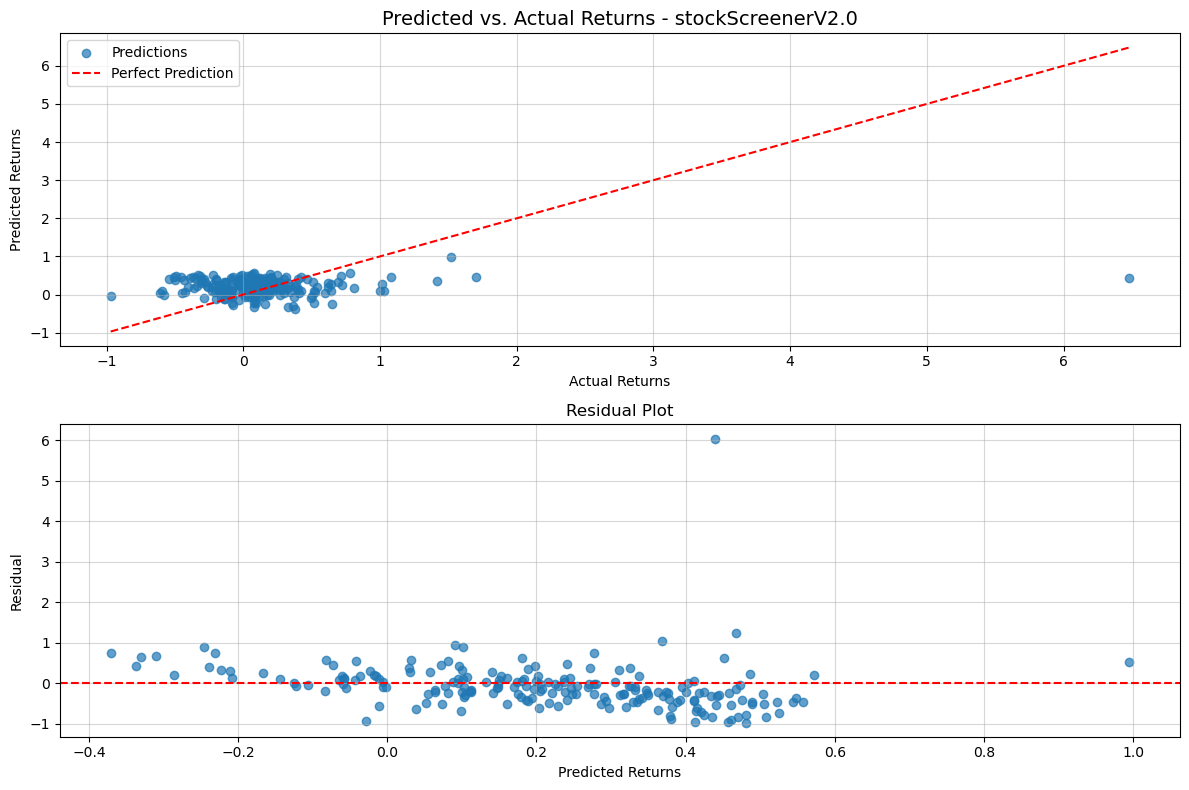

Collected 200 valid test tickers (target: 200)

Evaluation Results:
MAE: 0.370
RMSE: 0.605
R²: -0.081


In [ ]:
def logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": model_name,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(test_tickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plotResults(results_df, model_name, model_folder):
    """Create and save visualization plots using all data points."""
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7, label='Predictions')
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(alpha=0.5)
    
    plt.subplot(2, 1, 2)
    plt.scatter(results_df['Predicted'], results_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Returns')
    plt.ylabel('Residual')
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    plt.show()

if trainNewModel:
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    validTestData = []
    attempted_tickers = set()
    attempts = 0

    if testSize * 4 <= len(tickers):  
        max_attempts = testSize * 4 # Prevent infinite loops
    else:
        max_attempts = len(tickers)

    # Keep trying until we reach testSize or exhaust attempts
    while len(validTestData) < testSize and attempts < max_attempts:
        # Get a new ticker we haven't tried yet
        remaining_tickers = [t for t in nonTrainingTickers if t not in attempted_tickers]
        if not remaining_tickers:  # If all tried, reset attempted list
            attempted_tickers = set()
            remaining_tickers = nonTrainingTickers
            
        ticker = np.random.choice(remaining_tickers)
        attempted_tickers.add(ticker)
        attempts += 1

        # Fetch and validate data
        data = getTickerDataFrom1YrAgo(ticker)
        if not data.empty and not data[['EV/EBIT', 'ROIC']].isna().any().any():
            validTestData.append(data)

    if not validTestData:
        raise ValueError("No valid test data collected after multiple attempts")
        
    # Trim to exact testSize if we collected more
    validTestData = validTestData[:testSize]  
    combinedTestData = pd.concat(validTestData, ignore_index=True)

    # Clean data
    test_data_clean = combinedTestData.dropna(subset=['EV/EBIT', 'ROIC', 'Future Year Change'])
    
    if test_data_clean.empty:
        raise ValueError("No valid test data after cleaning NaN values")

    # Create test dataloader
    test_dl = learn.dls.test_dl(test_data_clean)
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Predicted': preds.numpy().flatten(),
        'Actual': targs.numpy().flatten()
    })
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Calculate metrics
    mae = np.mean(np.abs(results_df['Residual']))
    rmse = np.sqrt(np.mean(results_df['Residual']**2))
    r2 = 1 - (np.sum(results_df['Residual']**2) / np.sum((results_df['Actual'] - results_df['Actual'].mean())**2))

    # Log and plot
    logEvaluation(modelName, mae, rmse, r2, modelFolder, test_data_clean['Ticker'].unique())
    plotResults(results_df, modelName, modelFolder)

    # Show collection stats
    print(f"Collected {len(validTestData)} valid test tickers (target: {testSize})")
    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts ({max_attempts}). Some invalid tickers may remain.")  
    print(f"\nEvaluation Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

## Predictions

In [46]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV2.0.pkl
stockScreenerV1.5.pkl
stockScreenerV1.4.pkl
stockScreenerV1.6.pkl
stockScreenerV1.7.pkl
stockScreenerV1.3.pkl
stockScreenerV1.2.pkl
stockScreenerV1.0.pkl
stockScreenerV1.1.pkl
stockScreenerV1.9.pkl
stockScreenerV1.8.pkl
stockScreenerV1.10.pkl


In [47]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV1.7
Timestamp      2025-01-27 08:45
MAE                       0.328
RMSE                      0.739
R2                        0.077
Name: 7, dtype: object

### Load model

In [48]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
else:
    pathlib.WindowsPath = pathlib.PosixPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

In [49]:
#predictionTarget = '95%'

In [ ]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Drop rows with NaN values in 'EV/EBIT' or 'ROIC'
    dfPrediction = dfPrediction.dropna(subset=['EV/EBIT', 'ROIC'])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

Prediction for DRS (Unknown):
1.40%
Free money?!
